In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

#Import module from folder in another directory
import importlib.util
spec = importlib.util.spec_from_file_location("outliers", "data_preprocessing/outliers.py")
outliers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(outliers)

import sys
sys.path.append('data_preprocessing')
import data_preprocessing.summary as summary
import data_preprocessing.normalize as normalize

import warnings
warnings.filterwarnings("ignore")

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

%matplotlib inline

rng = np.random.RandomState(31337)

In [4]:
train_data = pd.read_csv('../data/input/ames_train.csv')
test_data = pd.read_csv('../data/input/ames_test.csv')

geo_train_data = pd.read_csv('../data/input/ames_geodemo_train.csv')
geo_test_data = pd.read_csv('../data/input/ames_geodemo_train.csv')

# Modelling without geo/census data

In [5]:
train_data = normalize.fill_in_missing_values(train_data)
train_data = outliers.remove_outliers(train_data)
#train_data = normalize.normalize(train_data)

test_data = normalize.fill_in_missing_values(test_data)
test_data = outliers.remove_outliers(test_data)
#test_data = normalize.normalize(test_data)

In [6]:
train_data = train_data.select_dtypes(include=[np.number])
test_data = test_data.select_dtypes(include=[np.number])

X_train, X_test, y_train, y_test = train_test_split(train_data.loc[:, train_data.columns != 'SalePrice'], 
                                                  train_data['SalePrice'],
                                                  test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

## Random Forest

In [7]:
clf = RandomForestRegressor(n_estimators=500)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

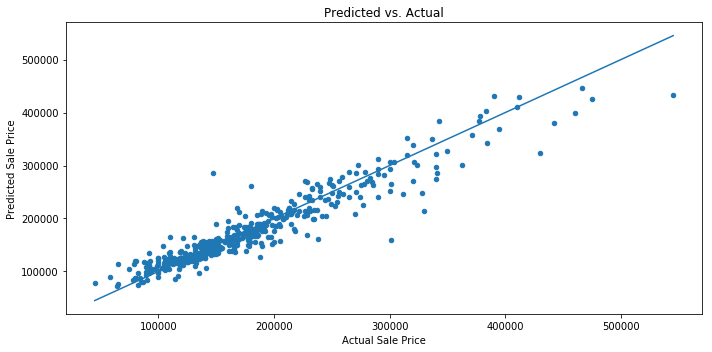

In [8]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [9]:
print("r2 score: ",r2_score(y_test,y_pred))
print("Mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))

r2 score:  0.897035554506
Mean squared error:  24224.52855502991


## XGBoost with 5 folds

In [10]:
kf = KFold(n_splits=5,shuffle=True,random_state=rng)
for train_index,test_index in kf.split(X_train):
    clf = xgb.XGBRegressor().fit(X_train[train_index],y_train[train_index])
    y_pred = clf.predict(X_train[test_index])
    actual = y_train[test_index]
    print("r2 score: ",r2_score(actual,y_pred))
    print("Mean squared error: ", math.sqrt(mean_squared_error(actual,y_pred)))

r2 score:  0.907934669253
Mean squared error:  22782.822415558046
r2 score:  0.916366275013
Mean squared error:  21079.99113056693
r2 score:  0.895943157706
Mean squared error:  24552.387258227143
r2 score:  0.92295454301
Mean squared error:  22631.478867496717
r2 score:  0.917325169007
Mean squared error:  19987.657520587047


## Simple XGBoost

In [11]:
clf = xgb.XGBRegressor()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

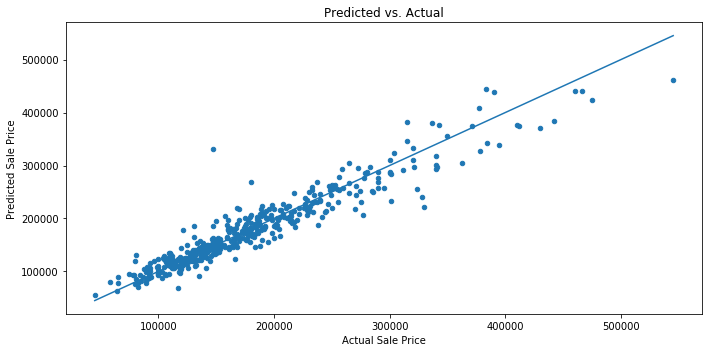

In [12]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [13]:
print("r2 score: ",r2_score(y_test,y_pred))
print("Mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))

r2 score:  0.904284390825
Mean squared error:  23356.24784725634


## GridSearchCV With xgboost parameter optimisation

In [91]:
xgb_clf = xgb.XGBRegressor()
gridSearchClf = GridSearchCV(xgb_clf, {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)
gridSearchClf.fit(X_train,y_train)
y_pred = gridSearchClf.predict(X_test)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    7.8s finished


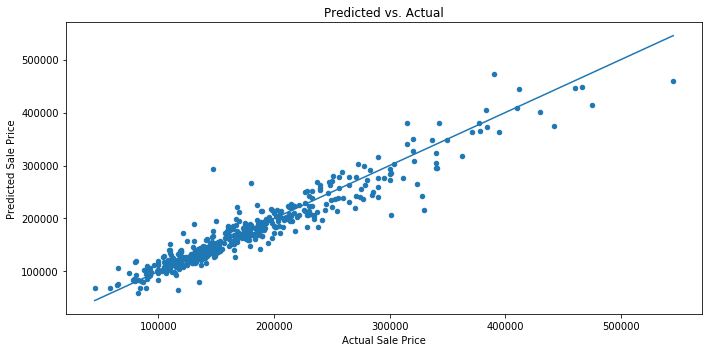

In [92]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [93]:
print("r2 score: ",r2_score(y_test,y_pred))
print("Mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))

r2 score:  0.911750236796
Mean squared error:  22426.859674883774


## Decision Tree Regression and Adaboosting Regression

In [94]:
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)

In [95]:
regr_1.fit(X_train,y_train)
y_pred = regr_1.predict(X_test)

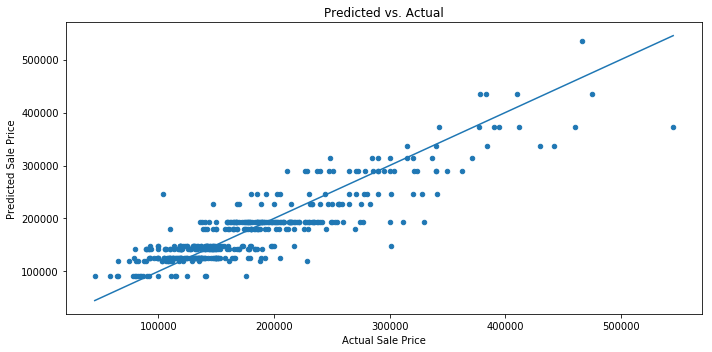

In [96]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [97]:
print("r2 score: ",r2_score(y_test,y_pred))
print("Mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))

r2 score:  0.775020476704
Mean squared error:  35808.25745976077


In [98]:
regr_2.fit(X_train,y_train)
y_pred = regr_2.predict(X_test)

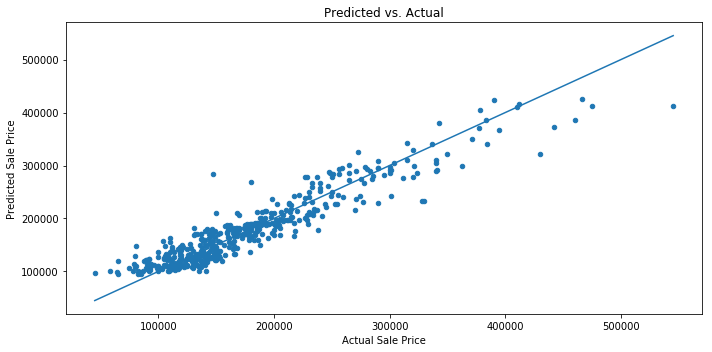

In [99]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [100]:
print("r2 score: ",r2_score(y_test,y_pred))
print("Mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))

r2 score:  0.880865912179
Mean squared error:  26057.318010358926


# Modelling with geo/census data 

In [101]:
geo_train_data = normalize.fill_in_missing_values(geo_train_data)
geo_train_data = outliers.remove_outliers(train_data)
#train_data = normalize.normalize(train_data)

geo_test_data = normalize.fill_in_missing_values(test_data)
geo_test_data = outliers.remove_outliers(test_data)
#test_data = normalize.normalize(test_data)

In [102]:
geo_train_data = geo_train_data.select_dtypes(include=[np.number])
geo_test_data = geo_test_data.select_dtypes(include=[np.number])

X_train, X_test, y_train, y_test = train_test_split(geo_train_data.loc[:, geo_train_data.columns != 'SalePrice'], 
                                                  geo_train_data['SalePrice'],
                                                  test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

## Random Forest 

In [103]:
clf = RandomForestRegressor(n_estimators=500)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

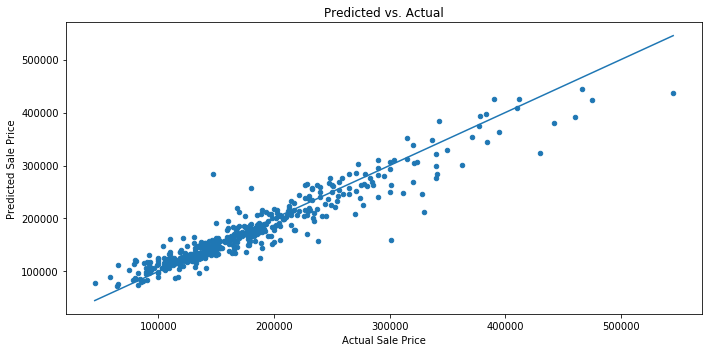

In [104]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [105]:
print("r2 score: ",r2_score(y_test,y_pred))
print("Mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))

r2 score:  0.897801440864
Mean squared error:  24134.265036583754


## XGBoost with 5 fold

In [107]:
kf = KFold(n_splits=5,shuffle=True,random_state=rng)
for train_index,test_index in kf.split(X_train):
    clf = xgb.XGBRegressor().fit(X_train[train_index],y_train[train_index])
    y_pred = clf.predict(X_train[test_index])
    actual = y_train[test_index]
    print("r2 score: ",r2_score(actual,y_pred))
    print("Mean squared error: ", math.sqrt(mean_squared_error(actual,y_pred)))

r2 score:  0.923028499708
Mean squared error:  21681.013934718532
r2 score:  0.914106875789
Mean squared error:  22447.067306932757
r2 score:  0.919074676109
Mean squared error:  19942.414927375077
r2 score:  0.900839167376
Mean squared error:  22062.172239042833
r2 score:  0.910590276912
Mean squared error:  23967.7491951001


In [109]:
clf = xgb.XGBRegressor()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

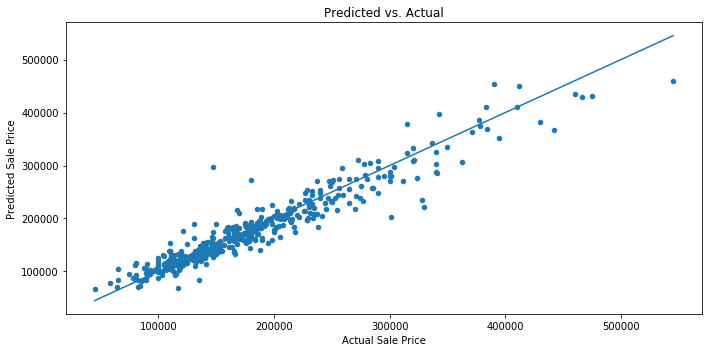

In [110]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [111]:
print("r2 score: ",r2_score(y_test,y_pred))
print("Mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))

r2 score:  0.911397226872
Mean squared error:  22471.670008582107


## Decision tree and Adaboosting

In [14]:
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)

In [15]:
regr_1.fit(X_train,y_train)
y_pred = regr_1.predict(X_test)

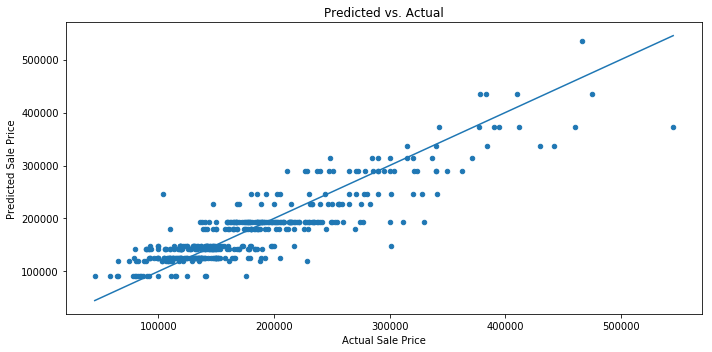

In [17]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [18]:
print("r2 score: ",r2_score(y_test,y_pred))
print("Mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))

r2 score:  0.775020476704
Mean squared error:  35808.25745976077


In [19]:
regr_2.fit(X_train,y_train)
y_pred = regr_2.predict(X_test)

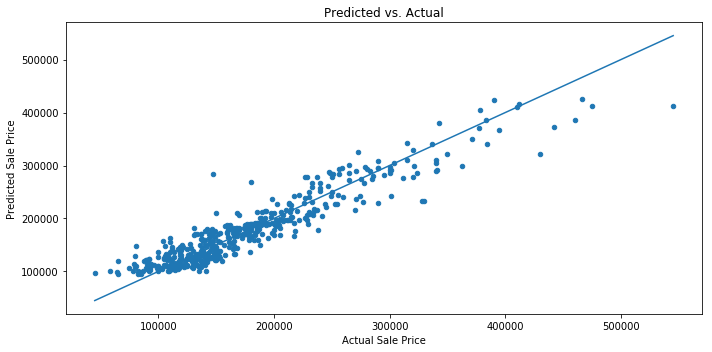

In [20]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [21]:
print("r2 score: ",r2_score(y_test,y_pred))
print("Mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))

r2 score:  0.880865912179
Mean squared error:  26057.318010358926
